# Please run on T4 GPU if using Colab!



### Setting up code for Audio Spectrogram Transformer

In [4]:
!git clone https://github.com/YuanGongND/ast.git
!git clone https://github.com/NimayRKumar/in_the_jungle.git
!apt install python3.10-venv
!python3 -m venv venvast
!source venvast/bin/activate

Cloning into 'ast'...
remote: Enumerating objects: 649, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 649 (delta 85), reused 129 (delta 75), pack-reused 503
Receiving objects: 100% (649/649), 2.42 MiB | 10.82 MiB/s, done.
Resolving deltas: 100% (345/345), done.
Cloning into 'in_the_jungle'...
remote: Enumerating objects: 1036, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 1036 (delta 55), reused 166 (delta 31), pack-reused 843
Receiving objects: 100% (1036/1036), 105.82 MiB | 12.31 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Updating files: 100% (921/921), done.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.10-venv is already the newest version (3.10.12-1~22.04.3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [5]:
%cd ast

/content/ast/ast


#### The requirements.txt from the AST github have deprecated versions so we use the following from our own ast_requirements.txt file instead. We can ignore the warning about matplotlib
llvmlite

matplotlib==3.4.2

numba

numpy

scikit-learn

scipy

timm==0.4.5

torch

torchaudio

torchvision

wget

zipp

In [3]:
!pip install -r /content/in_the_jungle/ast_requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 37.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 37.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.4.2-cp310-cp310-linux_x86_64.whl size=10436401 sha256=708d3a2f824c0a5c70ec54e4648a9a0e3bb04d076867b2341367fa2e1b90fb80
  Stored in directory: /root/.cache/pip/wheels/d9/e8/73/f806fc40c211022378c2828e3cce1eac412344111ab1becd9d
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=043b42a263a0bea101bf99d3ba3e297b4a8ed2e2c83876a168dd1a875f5cf7a3
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built matplotlib wget
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependen

In [6]:
%cd src
from models import ASTModel

/content/ast/ast/src


### Setting up our data pipeline

In [7]:
%cd ../../in_the_jungle

/content/ast/in_the_jungle


In [8]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.5 MB/s eta 0:00:00


In [9]:
!echo -n "/content/in_the_jungle/data" > data_dir_path.txt
!ls

ast.ipynb	      data		 label_encoding.JSON  README.md		Store
ast_requirements.txt  data_dir_path.txt  preprocess.py	      requirements.txt
cnn.ipynb	      figures		 __pycache__	      rnn.ipynb


### Preprocessing Data & Creating Datasets

In [17]:
from preprocess import label_encoding, create_signal, create_signal_dataframe, pad_or_trim_audio, augment_data, add_gaussian_noise, add_air_absorption, add_band_pass_filter, gain_transition, tanh_distortion
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
import os
import shutil
import json
from ast import literal_eval
from audiomentations import AddGaussianNoise, AirAbsorption, ApplyImpulseResponse, BandPassFilter, GainTransition, RepeatPart, TimeStretch, TanhDistortion
from sklearn.model_selection import train_test_split
import time
import copy

def get_spectrogram(signal, sr=22050):
    spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr)
    return librosa.amplitude_to_db(spectrogram)

def get_mfcc(signal, n_mfcc=13):
    return librosa.feature.mfcc(y=signal, n_mfcc=n_mfcc)


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
with open("./data_dir_path.txt") as f:
    data_dir = f.read()

df = pd.DataFrame(columns=["signal", "label"])
subdirs = [f for f in os.listdir(data_dir) if not f.startswith('.')]

for sd in subdirs:
    out_path = "{}/{}".format(data_dir, sd)
    for file in os.listdir("{}/wav".format(out_path)):
        sig = create_signal("{}/wav/{}".format(out_path, file), out_path)
        sig = pad_or_trim_audio(sig, 22050 * 2)
        df.loc[len(df)] = [sig, label_encoding[sd]]

In [19]:
signal = np.vstack(df["signal"])
label = np.array(df["label"])

x_train, x_test, y_train, y_test = train_test_split(signal, label, test_size=0.2)

### Augment Training Data
Comment the following block out to train without augmentations. We have chosen to augment with gaussian noise and air absorptions, but many more options are available

In [20]:
aug_list = [add_gaussian_noise, add_air_absorption]
x_train, y_train = augment_data(x_train, y_train, [add_gaussian_noise, add_air_absorption])

In [21]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

spectrogram_train = get_spectrogram(x_train, sr=16000)
spectrogram_test = get_spectrogram(x_test, sr=16000)
print(spectrogram_train.shape)

mfcc_train = get_mfcc(x_train, n_mfcc=20)
mfcc_test = get_mfcc(x_test, n_mfcc=20)
print(mfcc_train.shape)

(2100, 44100) (2100,) (175, 44100) (175,)
(2100, 128, 87)
(2100, 20, 87)


In [22]:
train_data_spectrogram = []
test_data_spectrogram = []

train_data_mfcc = []
test_data_mfcc = []

for i in range(spectrogram_train.shape[0]):
    train_data_spectrogram.append((spectrogram_train[i], y_train[i]))
    train_data_mfcc.append((mfcc_train[i], y_train[i]))

for i in range(spectrogram_test.shape[0]):
    test_data_spectrogram.append((spectrogram_test[i], y_test[i]))
    test_data_mfcc.append((mfcc_test[i], y_test[i]))


train_loader_spectrogram = torch.utils.data.DataLoader(train_data_spectrogram, batch_size=35)
train_loader_mfcc = torch.utils.data.DataLoader(train_data_mfcc, batch_size=35)

test_loader_spectrogram = torch.utils.data.DataLoader(test_data_spectrogram, batch_size=5)
test_loader_mfcc = torch.utils.data.DataLoader(test_data_mfcc, batch_size=5)

### Training Code

In [23]:
def train(net, optimizer, criterion, train_loader, test_loader, epochs):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []
    train_acc = []
    val_loss_values = []
    val_acc = []
    for epoch in range(epochs):
        print("epoch", epoch)
        correct = 0
        total = 0
        flag = 0
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            optimizer.step()
            # if (i+1) % 1000 == 0:
            #   print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            # if plot:
            #   info = { ('loss_' + model_name): loss.item() }

              #for tag, value in info.items():
                #logger.scalar_summary(tag, value, overall_step+1)
        train_loss_values.append(running_loss)
        train_acc.append(100 - 100*correct/total)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
        val_acc.append(100 - 100*correct/total)
        val_loss_values.append(running_loss)
    return val_acc,val_loss_values,train_acc,train_loss_values

### Setting up pre-trained AST Model and Training

In [24]:
%cd /content/ast/src/models

/content/ast/src/models


In [25]:
ast_mdl = ASTModel(label_dim=10, input_tdim=128, input_fdim=87, audioset_pretrain=True, imagenet_pretrain=True)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True
frequncey stride=10, time stride=10
number of patches=96


In [27]:
model = ast_mdl.to(device)
epochs = 50
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=10e-5, nesterov=True)
val_acc,val_loss_values,train_acc,train_loss_values= train(model, optimizer, criterion, train_loader_spectrogram, test_loader_spectrogram, epochs)

epoch 0
Accuracy of the network on the test images: 47.42857142857143 %
epoch 1
Accuracy of the network on the test images: 62.857142857142854 %
epoch 2
Accuracy of the network on the test images: 68.57142857142857 %
epoch 3
Accuracy of the network on the test images: 65.71428571428571 %
epoch 4
Accuracy of the network on the test images: 70.85714285714286 %
epoch 5
Accuracy of the network on the test images: 74.28571428571429 %
epoch 6
Accuracy of the network on the test images: 73.71428571428571 %
epoch 7
Accuracy of the network on the test images: 70.85714285714286 %
epoch 8
Accuracy of the network on the test images: 73.14285714285714 %
epoch 9
Accuracy of the network on the test images: 76.57142857142857 %
epoch 10
Accuracy of the network on the test images: 74.85714285714286 %
epoch 11
Accuracy of the network on the test images: 73.14285714285714 %
epoch 12
Accuracy of the network on the test images: 73.71428571428571 %
epoch 13
Accuracy of the network on the test images: 74.2857

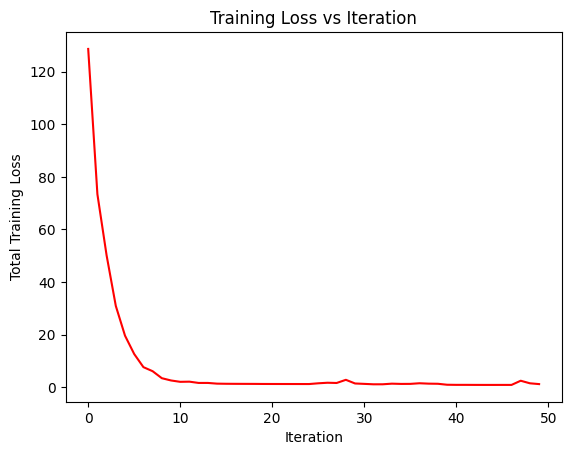

In [28]:
plt.plot(train_loss_values, 'r')
plt.title('Training Loss vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Total Training Loss')
plt.show()

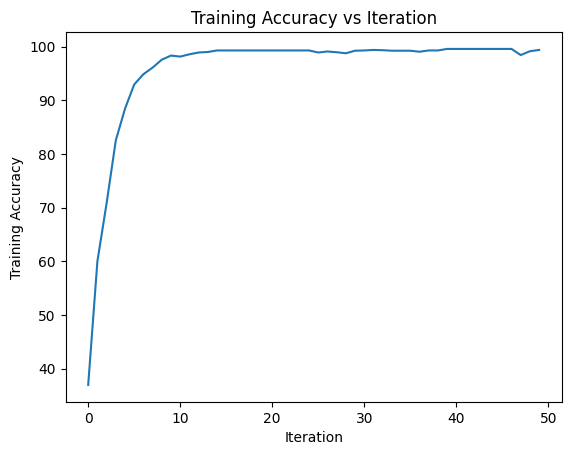

In [29]:
plt.plot([100 - _ for _ in train_acc])
plt.title('Training Accuracy vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Training Accuracy')
plt.show()

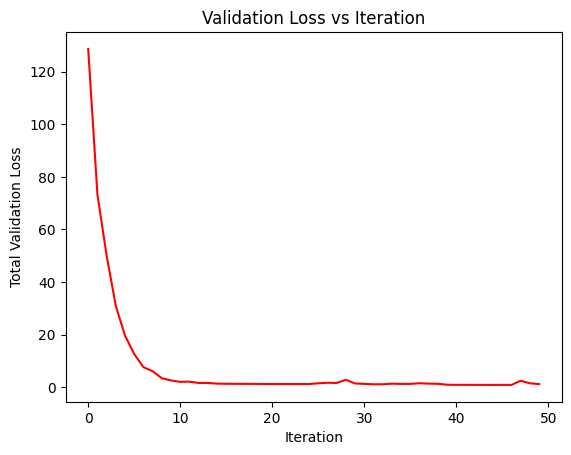

In [30]:
plt.plot(val_loss_values, 'r')
plt.title('Validation Loss vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Total Validation Loss')
plt.show()

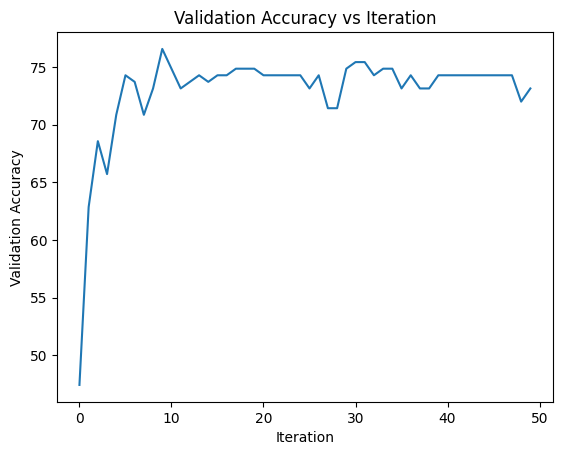

In [31]:
plt.plot([100 - _ for _ in val_acc])
plt.title('Validation Accuracy vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Validation Accuracy')
plt.show()